# Определение выгодного тарифа для телеком компании

### Цель проекта

Мы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов.

В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018-й год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание данных

Таблица `users` (информация о пользователях):

`user_id` — уникальный идентификатор пользователя;

`first_name` — имя пользователя;

`last_name` — фамилия пользователя;

`age` — возраст пользователя (годы);

`reg_date` — дата подключения тарифа (день, месяц, год);

`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);

`city` — город проживания пользователя;

`tariff` — название тарифного плана.

Таблица `calls` (информация о звонках):

`id` — уникальный номер звонка;

`call_date` — дата звонка;

`duration` — длительность звонка в минутах;

`user_id` — идентификатор пользователя, сделавшего звонок.

Таблица `messages` (информация о сообщениях):

`id` — уникальный номер сообщения;

`message_date` — дата сообщения;

`user_id` — идентификатор пользователя, отправившего сообщение.

Таблица `internet` (информация об интернет-сессиях):

`id` — уникальный номер сессии;

`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах);

`session_date` — дата интернет-сессии;

`user_id` — идентификатор пользователя.

Таблица `tariffs` (информация о тарифах):

`tariff_name` — название тарифа;

`rub_monthly_fee` — ежемесячная абонентская плата в рублях;

`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату;

`messages_included` — количество сообщений в месяц, включённых в абонентскую плату;

`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);

`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);

`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета;

`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета.

## Ознакомление с данными

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from math import ceil
from scipy import stats as st

In [26]:
data_calls=pd.read_csv('/datasets/calls.csv')

display (data_calls.head())

data_calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В данной таблице пропусков нет, нужно привести дату к верному формату.

In [2]:
data_internet=pd.read_csv('/datasets/internet.csv')
display(data_internet.tail())
data_internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Присутствует столбец, которого нет в описании: 'Unnamed: 0', его лучше удалить, хотя на дальнейшую работу с таблицей он не повлияет. Также нет пропусков, нужно привести дату к верному формату.

In [3]:
data_messages=pd.read_csv('/datasets/messages.csv')
display(data_messages.head())
data_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Нужно привести дату к верному формату. Пропусков нет.

In [4]:
data_tariffs=pd.read_csv('/datasets/tariffs.csv')
display(data_tariffs)
data_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [5]:
data_users=pd.read_csv('/datasets/users.csv')
display(data_users.tail())
data_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Пропуски в столбце 'churn_date' связаны с тем, что тариф еще действует. Нужно привести дату к верному формату. В столцах, где указаны ФИО и наименования города приводить к одному регистру значения не буду, т.к. написание единообразное.

<h2> Подготовка данных</h2>

In [6]:
data_internet.drop('Unnamed: 0', axis='columns', inplace=True) # Удалила ненужный столбец с дублирующимися значениями

# Приводим столбцы с датой к нудному формату в тех таблицах, где это требуется:
print('data_calls')
data_calls['call_date']=pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_calls.info()
print()

print('data_internet')
data_internet['session_date']=pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_internet.info()
print()

print('data_messages')
data_messages['message_date']=pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_messages.info()
print()

print('data_users')
data_users['churn_date']=pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users.info()

data_calls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB

data_internet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB

data_messages
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), 

Привела во всех таблицах столбцы с датой к верному формату и убедилась, что все сделано верно. Ошибок в данных я не увидела.

<h3>Посчитаем для каждого пользователя:
    
количество сделанных звонков и израсходованных минут разговора по месяцам;
количество отправленных сообщений по месяцам;
объем израсходованного интернет-трафика по месяцам;
помесячную выручку с каждого пользователя.</h3>

In [7]:
#Округлим минуты для целого, т.к. каждый звонок округляется отдельно по условиям оператора:
data_calls['duration']=data_calls['duration'].apply(np.ceil)
#Составим сводные таблицы по разным видам траффика:
data_calls['month']=data_calls['call_date'].dt.month
data_calls_grouped=data_calls.groupby(['user_id','month']).agg({'duration':['count', 'sum']}).reset_index()
data_calls_grouped.columns = ['user_id', 'month','min_count', 'min_sum']
display(data_calls_grouped.head())

data_messages['month']=data_messages['message_date'].dt.month
data_messages_grouped=data_messages.groupby(['user_id','month']).agg({'id':'count'}).reset_index()
data_messages_grouped.columns = ['user_id', 'month', 'messages']
display(data_messages_grouped.head())

data_internet['month']=data_internet['session_date'].dt.month
data_internet_grouped=data_internet.groupby(['user_id','month']).agg({'mb_used':'sum'}).reset_index()
display(data_internet_grouped.head())

,user_id,month,min_count,min_sum
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0


,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [8]:
# Объединим данные с разных таблиц в одну общую для дальнейщей работы с ней
data_traffic_sms_min=pd.merge(data_calls_grouped, data_messages_grouped,how='outer')
data_traffic=pd.merge(data_traffic_sms_min, data_internet_grouped,how='outer')
data_traffic_tariff=pd.merge(data_traffic, data_users[['user_id', 'tariff', 'city']], how='outer')
data_tariffs.rename(columns={'tariff_name':'tariff'}, inplace=True)
data_full=pd.merge(data_traffic_tariff, data_tariffs, how='outer')

display(data_full.head())

,user_id,month,min_count,min_sum,messages,mb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,22.0,159.0,22.0,2253.49,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6.0,43.0,172.0,60.0,23233.77,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7.0,47.0,340.0,75.0,14003.64,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8.0,52.0,408.0,81.0,14055.93,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9.0,58.0,466.0,57.0,14568.91,ultra,Краснодар,1000,30720,3000,1950,150,1,1


In [9]:
#Некоторые пользователи пользуются не всеми доступными опциями, поэтому чтобы не было пропущенных значений заполним их нолями.
data_full['min_sum']=data_full['min_sum'].fillna(0)
data_full['messages']=data_full['messages'].fillna(0)
data_full['mb_used']=data_full['mb_used'].fillna(0)

In [10]:
#Для подсчета выручки напишем функцию:
def benefit (row):
    #объявим переменные
    total_gb = 0
    total_messages = 0 
    total_minutes = 0
    min_sum = row['min_sum']
    messages = row['messages']
    mb_used = row ['mb_used']
    messages_included = row ['messages_included']
    minutes_included = row ['minutes_included']
    mb_per_month_included = row ['mb_per_month_included']
    rub_monthly_fee = row ['rub_monthly_fee']
    rub_per_gb = row ['rub_per_gb']
    rub_per_message = row ['rub_per_message']
    rub_per_minute = row ['rub_per_minute']
    
    if min_sum>minutes_included:
        total_minutes=(min_sum-minutes_included)*rub_per_minute
    if messages>messages_included:
        total_messages=(messages-messages_included)*rub_per_message
    if mb_used>mb_per_month_included:
        total_gb=np.ceil((mb_used-mb_per_month_included)/1024)*rub_per_gb #округлила Мб до Гб
    return total_minutes+total_messages+total_gb+rub_monthly_fee

data_full['benefit']=data_full.apply(benefit, axis=1)
display(data_full.head())

,user_id,month,min_count,min_sum,messages,mb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,benefit
0,1000,5.0,22.0,159.0,22.0,2253.49,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6.0,43.0,172.0,60.0,23233.77,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7.0,47.0,340.0,75.0,14003.64,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8.0,52.0,408.0,81.0,14055.93,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9.0,58.0,466.0,57.0,14568.91,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0


<h2> Анализ данных </h2>

In [33]:
print('Тариф "Ультра"')
data_ultra=data_full[['min_sum','messages','mb_used','tariff', 'benefit']].query('tariff=="ultra"')

#Определим дисперсию для траффика по тарифу "Ультра":
variance_minutes=np.var(data_ultra['min_sum'])
print('Дисперсия для звонков =',variance_minutes)

variance_messages=np.var(data_ultra['messages'])
print('Дисперсия для сообщений =',variance_messages)

variance_mb=np.var(data_ultra['mb_used'])
print('Дисперсия для интернета =',variance_mb)

variance_benefit=np.var(data_ultra['benefit'])
print('Дисперсия для выручки =',variance_benefit)

data_ultra.describe()

Тариф "Ультра"
Дисперсия для звонков = 100950.00623331097
Дисперсия для сообщений = 2283.0995570851965
Дисперсия для интернета = 101928648.60329504
Дисперсия для выручки = 141244.31956107615


,min_sum,messages,mb_used,benefit
count,986.000000,986.000000,986.000000,986.000000
mean,526.089249,49.313387,19449.059970,2070.030426
std,317.887549,47.806040,10101.095459,376.015578
min,0.000000,0.000000,0.000000,1950.000000
25%,282.500000,6.000000,11748.585000,1950.000000
50%,518.000000,38.000000,19304.020000,1950.000000
75%,751.750000,78.750000,26835.885000,1950.000000
max,1673.000000,224.000000,49745.690000,4800.000000


In [20]:
print('Тариф "Смарт"')
data_smart=data_full[['min_sum','messages','mb_used','tariff', 'benefit']].query('tariff=="smart"')

#Определим дисперсию для траффика по тарифу "Смарт":
variance_minutes=np.var(data_smart['min_sum'])
print('Дисперсия для звонков =',variance_minutes)

variance_messages=np.var(data_smart['messages'])
print('Дисперсия для сообщений =',variance_messages)

variance_mb=np.var(data_smart['mb_used'])
print('Дисперсия для интернета =',variance_mb)

variance_benefit=np.var(data_smart['benefit'])
print('Дисперсия для выручки =',variance_benefit)

data_smart.describe()

Тариф "smart"
Дисперсия для звонков = 36265.12415310985
Дисперсия для сообщений = 796.5978766916688
Дисперсия для интернета = 34549343.55148492
Дисперсия для выручки = 669430.4361979931


,min_sum,messages,mb_used,benefit
count,2230.000000,2230.000000,2230.000000,2230.000000
mean,417.747534,33.369058,16201.118655,1289.641704
std,190.476754,28.230396,5879.187315,818.370799
min,0.000000,0.000000,0.000000,550.000000
25%,282.000000,10.000000,12630.035000,550.000000
50%,421.500000,28.000000,16505.475000,1021.000000
75%,545.000000,51.000000,20042.107500,1750.000000
max,1435.000000,143.000000,38552.450000,6770.000000


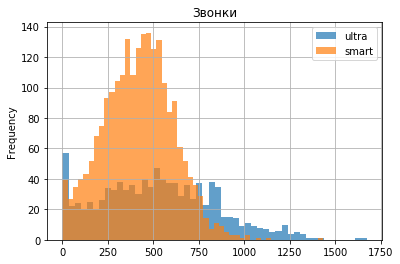

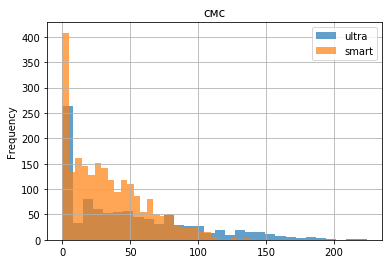

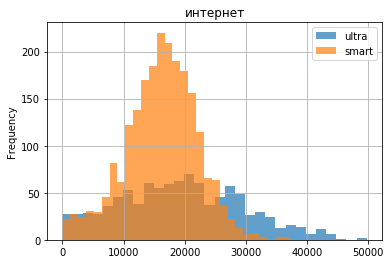

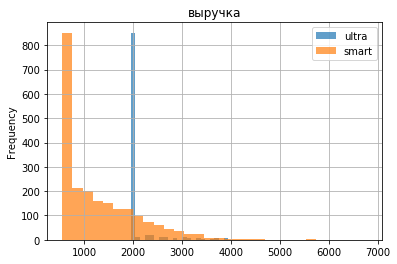

In [13]:
ax=data_full.query('tariff=="ultra"').plot(kind='hist',
    y='min_sum', bins=50, linewidth=5,alpha=0.7,label='ultra')

data_full.query('tariff=="smart"').plot(kind='hist',
    y='min_sum', bins=50, title='Звонки',linewidth=5, alpha=0.7,label='smart',ax=ax,grid=True,legend=True)


ax=data_full.query('tariff=="ultra"').plot(kind='hist',
    y='messages', bins=30, linewidth=5,alpha=0.7,label='ultra')

data_full.query('tariff=="smart"').plot(kind='hist',
    y='messages', bins=30, title='смс',linewidth=5, alpha=0.7,label='smart',ax=ax,grid=True,legend=True)

ax=data_full.query('tariff=="ultra"').plot(kind='hist',
    y='mb_used', bins=30, linewidth=5,alpha=0.7,label='ultra')

data_full.query('tariff=="smart"').plot(kind='hist',
    y='mb_used', bins=30, title='интернет',linewidth=5, alpha=0.7,label='smart',ax=ax,grid=True,legend=True)

ax=data_full.query('tariff=="ultra"').plot(kind='hist',
    y='benefit', bins=30, linewidth=5,alpha=0.7,label='ultra')

data_full.query('tariff=="smart"').plot(kind='hist',
    y='benefit', bins=30, title='выручка',linewidth=5, alpha=0.7,label='smart',ax=ax,grid=True,legend=True)

Пользователи тарифа «Ультра» в среднем больше общаются по телефону, больше отправляют сообщений и больше тратят интернет-траффика, при этом они рреже выходят за пределы траффика и, соответственно, меньше приносят выручки сверх стоимости тарифного плана, зато пользователи тарифа «Смарт» часто покупают дополнительные опции и в среднем покупают больше дополнительного траффика. 

<h2>Проверка гипотез </h2> 

### Первая гипотеза

Нулевая гипотеза: средняя выручка пользователей тарифов "Ультра" и "Смарт" равны. 
Альтернативная гипотеза: средняя выручка на разных тарифах различается.

In [29]:
#Подготовим выборки:
ultra_benefit=data_full[data_full['tariff']=='ultra']['benefit']
smart_benefit=data_full[data_full['tariff']=='smart']['benefit']
alpha = 0.05 # зададим критический уровень статистической значимости
results = st.ttest_ind(ultra_benefit, smart_benefit) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")  

p-значение: 8.081909555489933e-161
Отвергаем нулевую гипотезу
2070.030425963489
1289.6417040358745


Средняя выручка на тарифах различается, поэтому отвергаем нулевую гипотезу.

### Вторая гипотеза

Нулевая гипотеза: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.
Альтернативная гипотеза: средняя выручка пользователей ииз Москвы отличается от выручки пользователей из других регионов

In [32]:
moscow_city=data_full[data_full['city']=='Москва']['benefit']
other_city=data_full[data_full['city']!='Москва']['benefit']
alpha = 0.05 # зададим критический уровень статистической значимости
results = st.ttest_ind(moscow_city, other_city) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу
1546.7135842880523
1524.7251439539348


Средняя выручка не сильно отличается в зависимости от места проживания абонента, поэтому отвергнуть нулевую гипотезу мы не можем.

<h2>Выводы</h2>

По результатам работы с данным заданием могу сделать следующие выводы: данные довольно "чистые" подготовка потребовалась минимальная.
Если ориентироваться только на средний чек, то для оператора выгоднее тариф "Ультра", если же смотреть по дополнительным покупкам траффика, то на тарифе "Смарт" чаще идут дополнительные покупки, что полезно для бизнеса. При этом выручка слабо зависит от места нахождения абонентов.